In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
# The original jupyter notebook is at: https://osf.io/5cw7n
#
import os
import time
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
import pandas as pd
import seaborn as sns

from multiprocessing import Pool
import tqdm

import mne
mne.set_log_level(False)

# conda --version && python --version
# conda 23.10.0
# Python 3.11.5
# python -c "import mne; print(mne.__version__)"
# 1.6.1
import platform
print("using python version: ", platform.python_version())
print("using mne version: ", mne.__version__)

using python version:  3.11.5
using mne version:  1.6.1


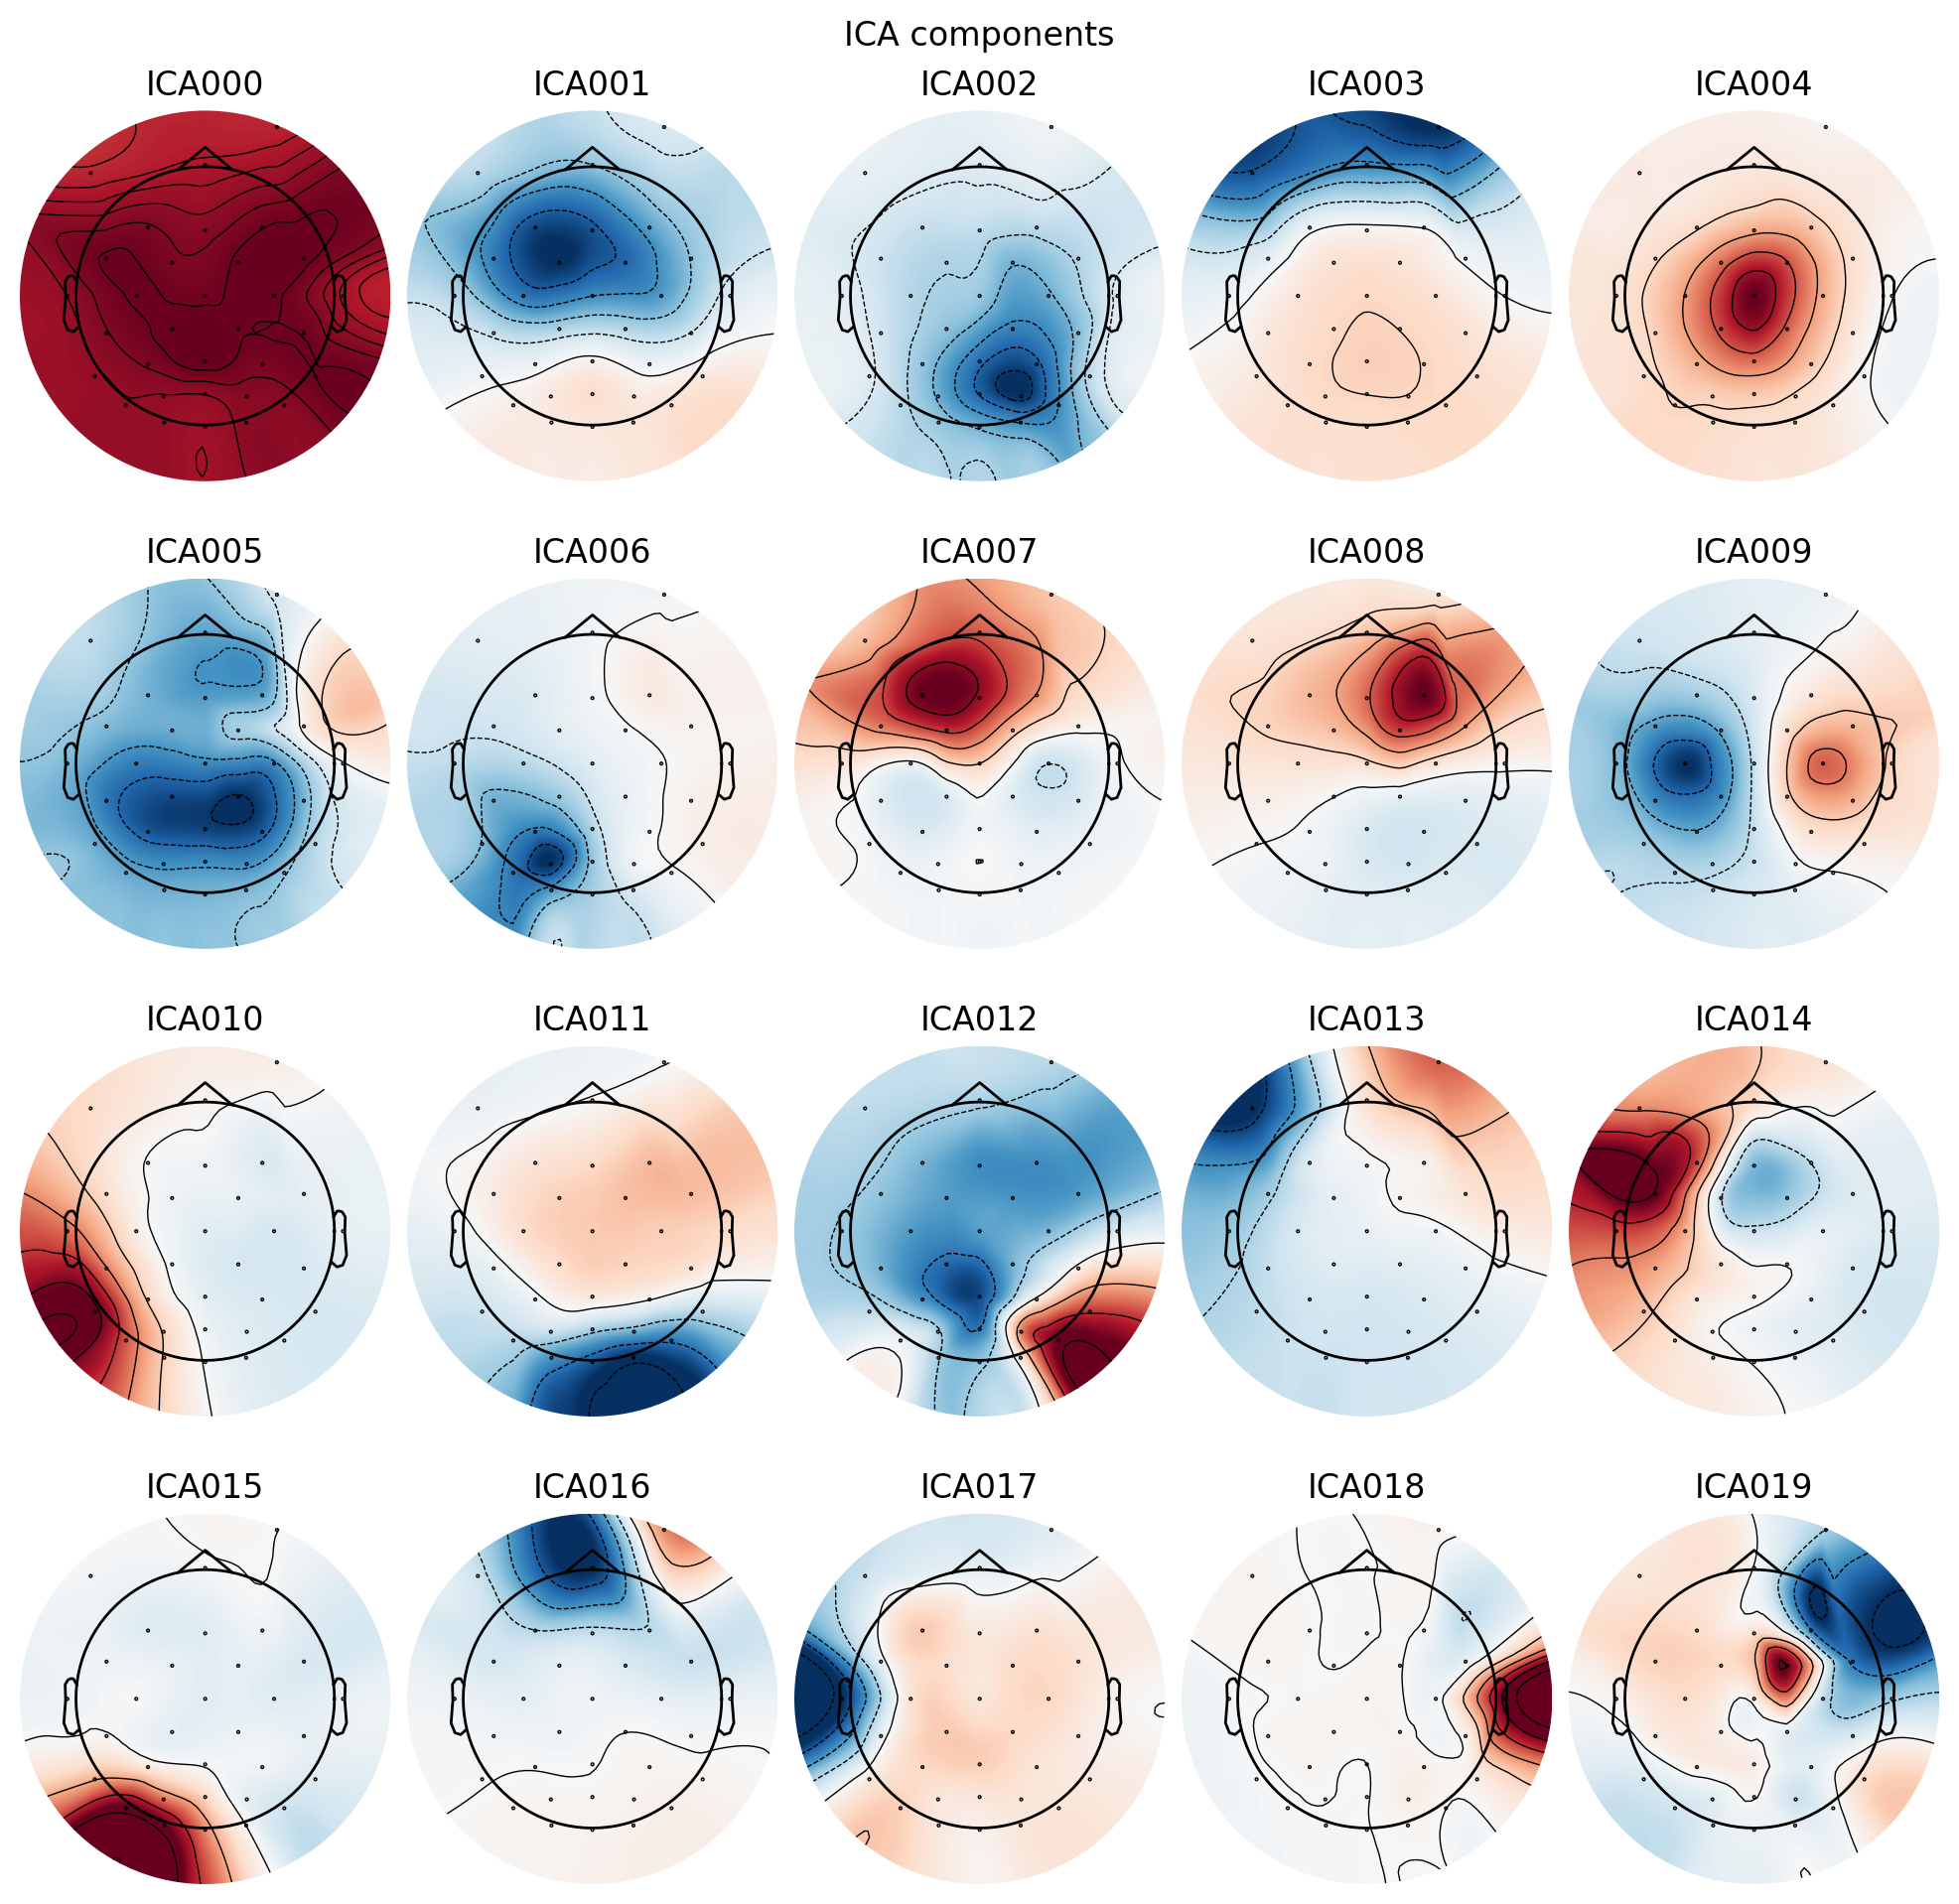

In [4]:
from mne.datasets import testing
data_path = testing.data_path()
fname = data_path / "EEGLAB/test_raw.set"
locs_info_path = data_path / "EEGLAB/test_chans.locs"

raw = mne.io.read_raw_eeglab(fname, preload=True)

montage = mne.channels.read_custom_montage(locs_info_path)
# import correct channel names
new_chan_names = np.loadtxt(locs_info_path, dtype=str, usecols=3)
# get old channel names
old_chan_names = raw.info["ch_names"]
# create a dictionary to match old channel names and new (correct) channel names
chan_names_dict = {old_chan_names[i]:new_chan_names[i] for i in range(32)}
# update the channel names in the dataset
raw.rename_channels(chan_names_dict)

raw.set_montage(montage)
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw.copy().filter(20, 50))
ica.plot_components()                 # outlines="skirt");
ica.exclude = [3, 13, 16]
raw = ica.apply(raw, exclude=ica.exclude).filter(.1, 30)
raw.resample(100)

#raw.drop_channels(["STI 014"])

conn, names = mne.channels.find_ch_adjacency(raw.info, "eeg")            

#conn, names = mne.channels.find_ch_connectivity(raw.info, "eeg")

In [5]:
topo = ica.get_components()[:, 1]

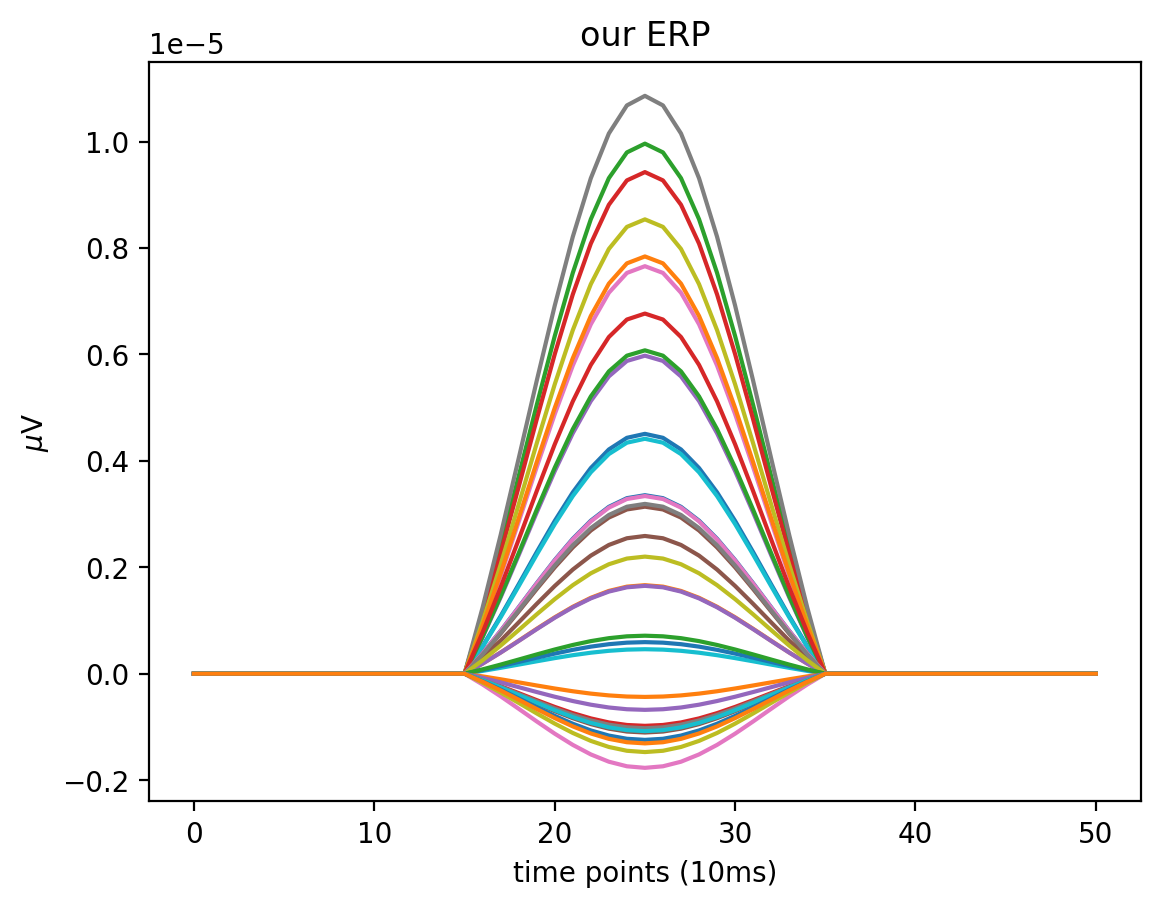

In [6]:
pre_stim = np.zeros(15)
post_stim = np.zeros(15)
erp = minmax_scale(norm.pdf(np.linspace(-1.5, 1.5, 21)))

erp = np.hstack((pre_stim, erp, post_stim)) * 1e-5 * 1.5
erp = np.array([erp] * 32) * -topo[:, np.newaxis]

plt.plot(erp.T)
plt.title("our ERP");  # the sharp boundaries are intentional to make the onset objective
plt.xlabel("time points (10ms)")
plt.ylabel("$\mu$V");

In [7]:
def make_epochs(effsize=1):
    try:
        onset = np.random.uniform()
        raw_ = raw.copy().crop(onset)
        epochs_onset = np.random.choice((0, 1, 2))
        events = mne.make_fixed_length_events(raw_, duration=.5)[epochs_onset::3]
        events = events[sorted(np.random.choice(len(events), size=100, replace=False))]
        events[::2, -1] += 1
        epochs = mne.Epochs(raw_, events, preload=True).apply_baseline().crop(0, .5)
        data = epochs.get_data(copy=False)
        data += (np.array([erp if ii % 2 else np.zeros(erp.shape) for ii, _ in enumerate(events)]) * effsize)
        return epochs
    except Exception:
        return make_epochs(effsize=effsize)

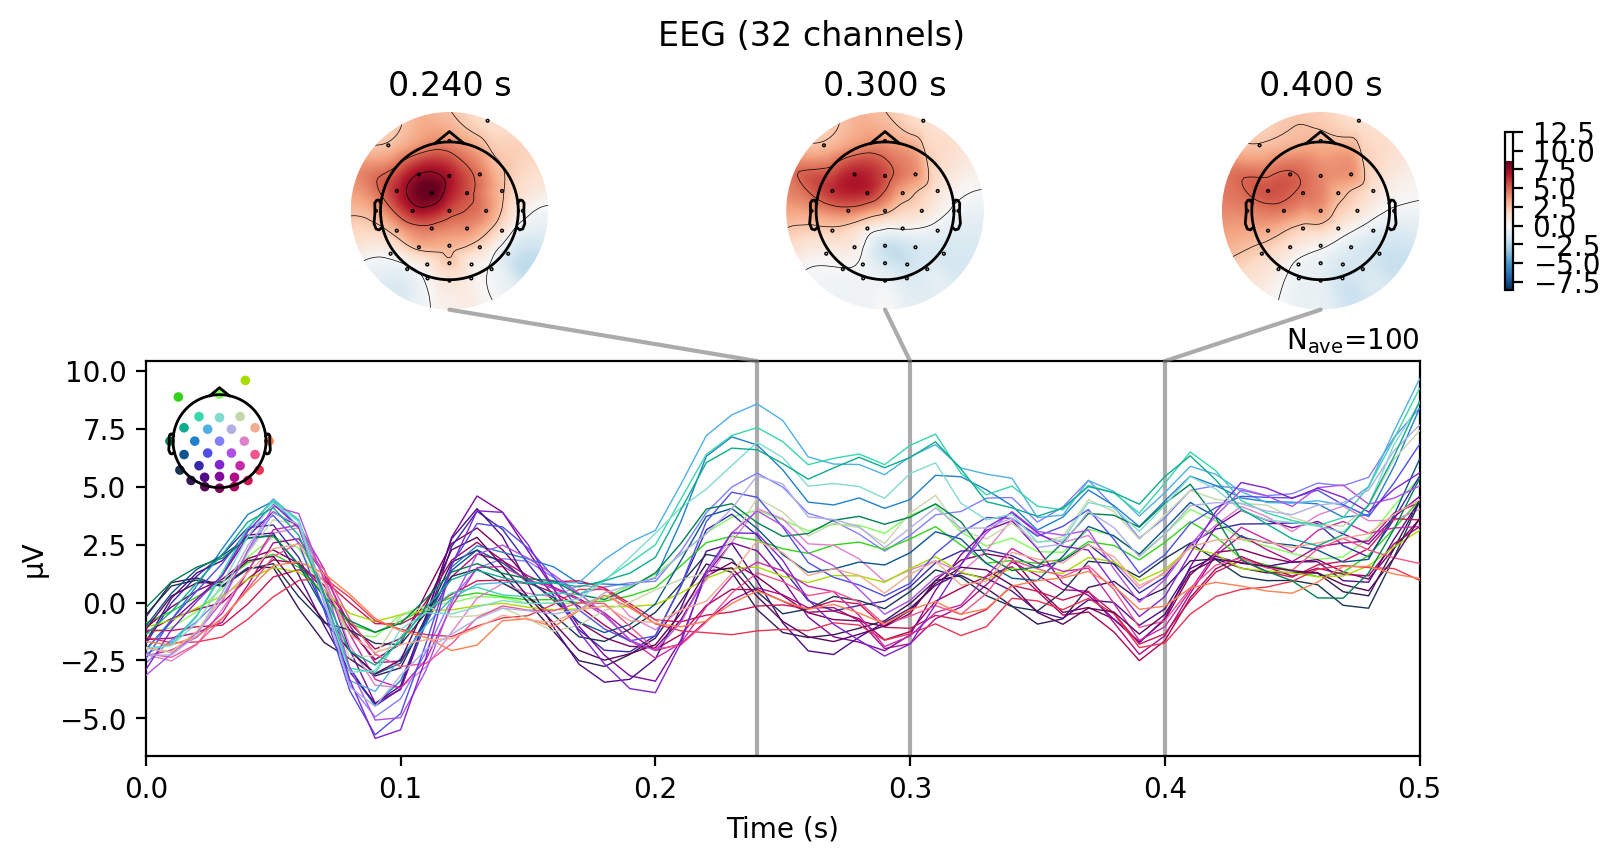

In [8]:
make_epochs().average().plot_joint();

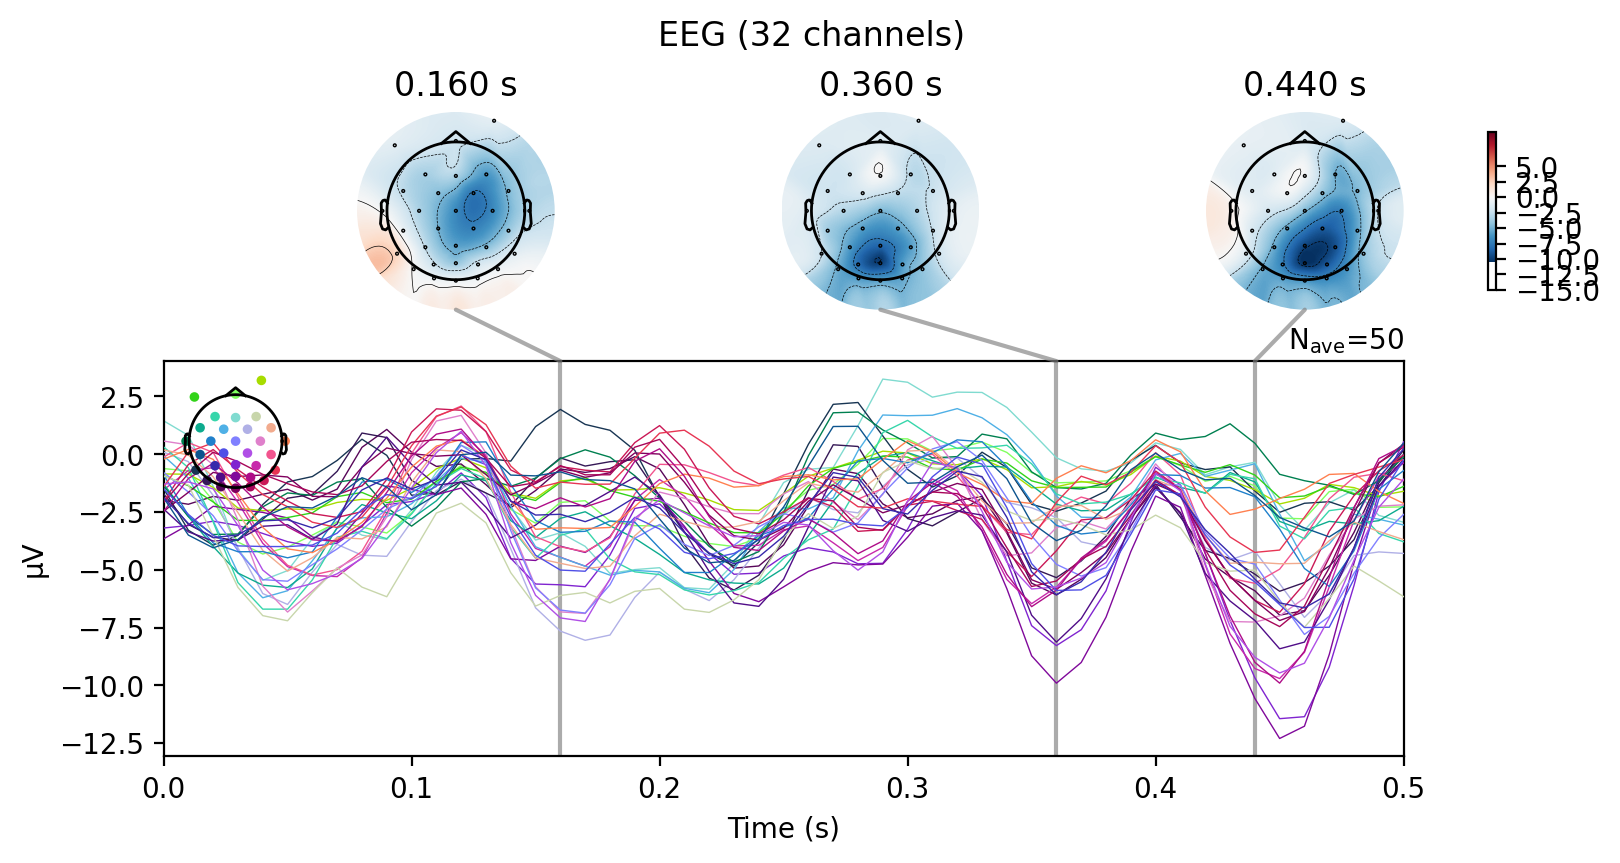

In [9]:
make_epochs()["2"].average().plot_joint();

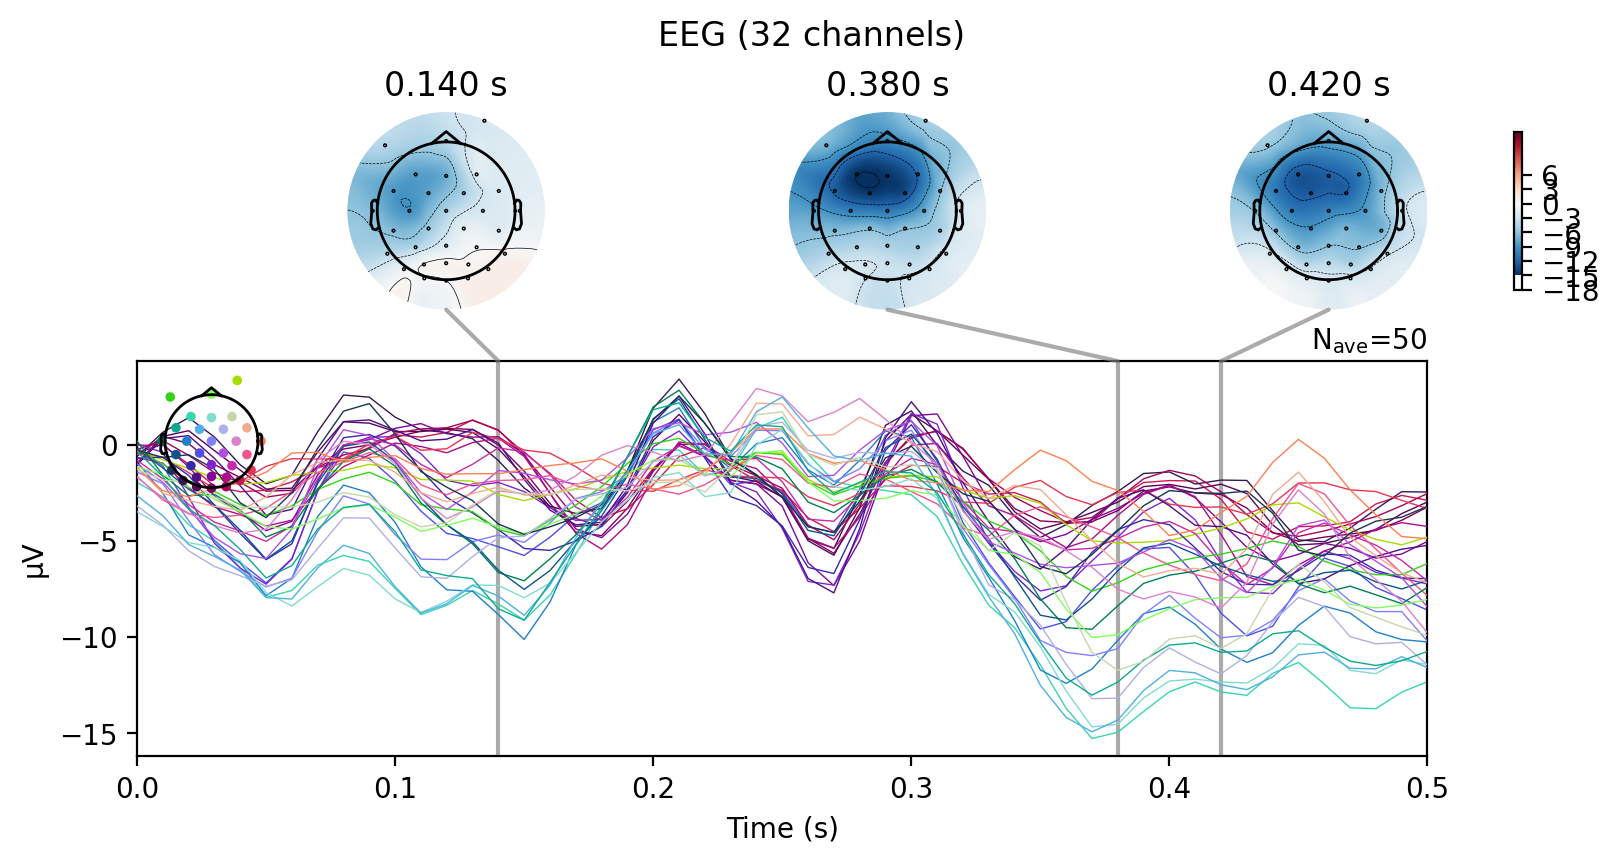

In [10]:
make_epochs()["1"].average().plot_joint();

In [54]:
def find_cluster_characteristics(epochs):
    data_1,  data_2 = epochs["1"].get_data(copy=False), epochs["2"].get_data(copy=False)
    res = mne.stats.permutation_cluster_test(
        [data_1.swapaxes(1, 2), data_2.swapaxes(1, 2)], n_permutations=1000,
        tail=1, adjacency=conn)
    t_obs, clusters, cluster_pv, H0 = res
    sign_clusters = cluster_pv < .95 # .05
    
    if not sign_clusters.sum():
        return None  # no sign clusters
        
    # this is terribly convoluted, but it#s really only looking for the first datapoint
    # included in any significant cluster
    # earliest_sign_datapoint = np.where((np.sum(np.array(clusters)[     # problem
    #     np.where(sign_clusters)[0]], 0).sum(1) > 0))[0].min()

    earliest_sign_datapoint=[]
    for ii in range(len(sign_clusters)):
        if (sign_clusters[ii]):
            earliest_sign_datapoint.append(clusters[ii][0])
            earliest_sign_datapoint.append(clusters[ii][1])            
    
    return earliest_sign_datapoint, sign_clusters.sum()

def make_one_run(ignore, effsize=1):
    return find_cluster_characteristics(make_epochs(effsize=effsize))

In [84]:
#%%capture

np.random.seed(seed=42)  # not sure if the works for scipy, etc

no_pool=False

# n=1 takes ~5.7 sec per simulation, n=8 ~45sec, n=100 ~9.5min, 10,000 would take too long
n = 4 

all_results = dict()
effsizes = (.5, .75, 1) #, 1, 1.25, 1.5)

start = time.time()

for ii, effsize in enumerate(effsizes):
    if no_pool:
        temp=[]
        for _ in range(n):
            temp.append(make_one_run(range(n)))
            
        all_results[ii] = temp
    else:
        def make_one_run_(x):
            return make_one_run(x, effsize=effsize)
    
        with Pool() as p:
            all_results[ii] = list(tqdm.tqdm(p.imap(make_one_run_, range(n)), total=n))

# Calculate wallclock time taken
end = time.time()
elapsed_time = end - start
print("elapsed time = %d seconds", elapsed_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.12it/s]

elapsed time = %d seconds 21.95380425453186


In [85]:
results = all_results[0]
results[0]

([array([5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8]),
  array([28, 23, 28, 31, 23, 28, 27, 31, 30, 28, 31]),
  array([6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 9, 9]),
  array([ 3,  4,  7,  8, 13,  9,  3,  4,  7,  8, 13,  9,  7,  7, 11]),
  array([24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 27]),
  array([2, 0, 2, 3, 6, 7, 0, 2, 3, 7, 3]),
  array([31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34,
         34, 34, 35, 35]),
  array([24, 25, 29, 24, 25, 29, 30, 31, 28, 25, 29, 30, 31, 27, 28, 23, 28,
         27, 31, 23, 28])],
 4)

In [86]:
print("all_results (num effect sizes): ", len(all_results))  # length will be same as number of effect sizes used
print("results for [0] (includin None rows: ", len(results))

# filter out None
res = []
for val in results:
    if val != None :
        res.append(val)

print("res rows and res[0] cols: ", len(res))

# for ii in range(len(all_results)):
#     results = all_results[ii]     # use index 0, 1, ... but some will be None
#     claims = [r for r in results if r]
#     for jj in range(len(claims)):
#         print( len(claims[jj] ), len(claims[jj][0])  )
#     print("---------------------------------")

all_results (num effect sizes):  3
results for [0] (includin None rows:  8
res rows and res[0] cols:  8


In [87]:
#
# claims is an array of 2 arrays of equal length,
# what do the two arrays represent???
#
results= all_results[0]
for ii in (range(len(results))):
    claims = results[ii]
    if claims:
        print("length of claim:", len(claims[0][0]))
        #print(claims)
        break

length of claim: 11


In [88]:
#results[4]

In [89]:
def plot_results(claims, effect_size, fig_num):
    
    fig, [ax1, ax2] = plt.subplots(ncols=2)
    fig.set_size_inches(12, 4)
    
    # smallest effect size [0], next smallest [1], ...
    # for smaller effect size, event detection tends to be later (and after real onset)??????
    
    # 10 ms time steps
    # r[0] here, was r
    sns.histplot([r[0] * 10 for r in claims], ax=ax1, kde_kws=dict(bw=10), bins=20)
    ax1.axvline(16 * 10, c="crimson", label="real onset")
    ax1.set_ylabel("cases (%)")
    ax1.set_xlabel("earliest point included in any significant cluster (msec)")

    ax1.set_yticks(ax1.get_yticks())
    ax1.set_yticklabels([round(label * 100, 2) for label in ax1.get_yticks()])
    
    ax1.legend()
    sns.despine()
    
    ax2.axhline(.05, c="r", label="nominal 5% level")
    ax2.set_ylabel("underestimations (cumulative %)")
    ax2.set_xlabel("degree of underestimation of onset (msec)")
    
    # s is a []
    # s = ((pd.Series(([-min(min(r[0] - 16), 0) * 10 for r in claims])).value_counts() / total_claims)
    #      .sort_index(ascending=False).cumsum().sort_index())[1:]
    
    # error (where detected onset is before true onset time)
    # if s.any():
    #     s.plot(ax=ax2, kind="bar", color="C1")

    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels([int(label * 100) for label in ax2.get_yticks()])
    
    sns.despine()

    fig.suptitle('Onset Detection: Effect Size %0.2f' % effect_size, fontsize=16)
    
    if (os.path.isdir("figs") == False):
        os.mkdir("figs")
    fig.savefig("figs/clusterf%d.pdf"%fig_num, bbox_inches="tight")

total claims= 8
total claims= 8
total claims= 8


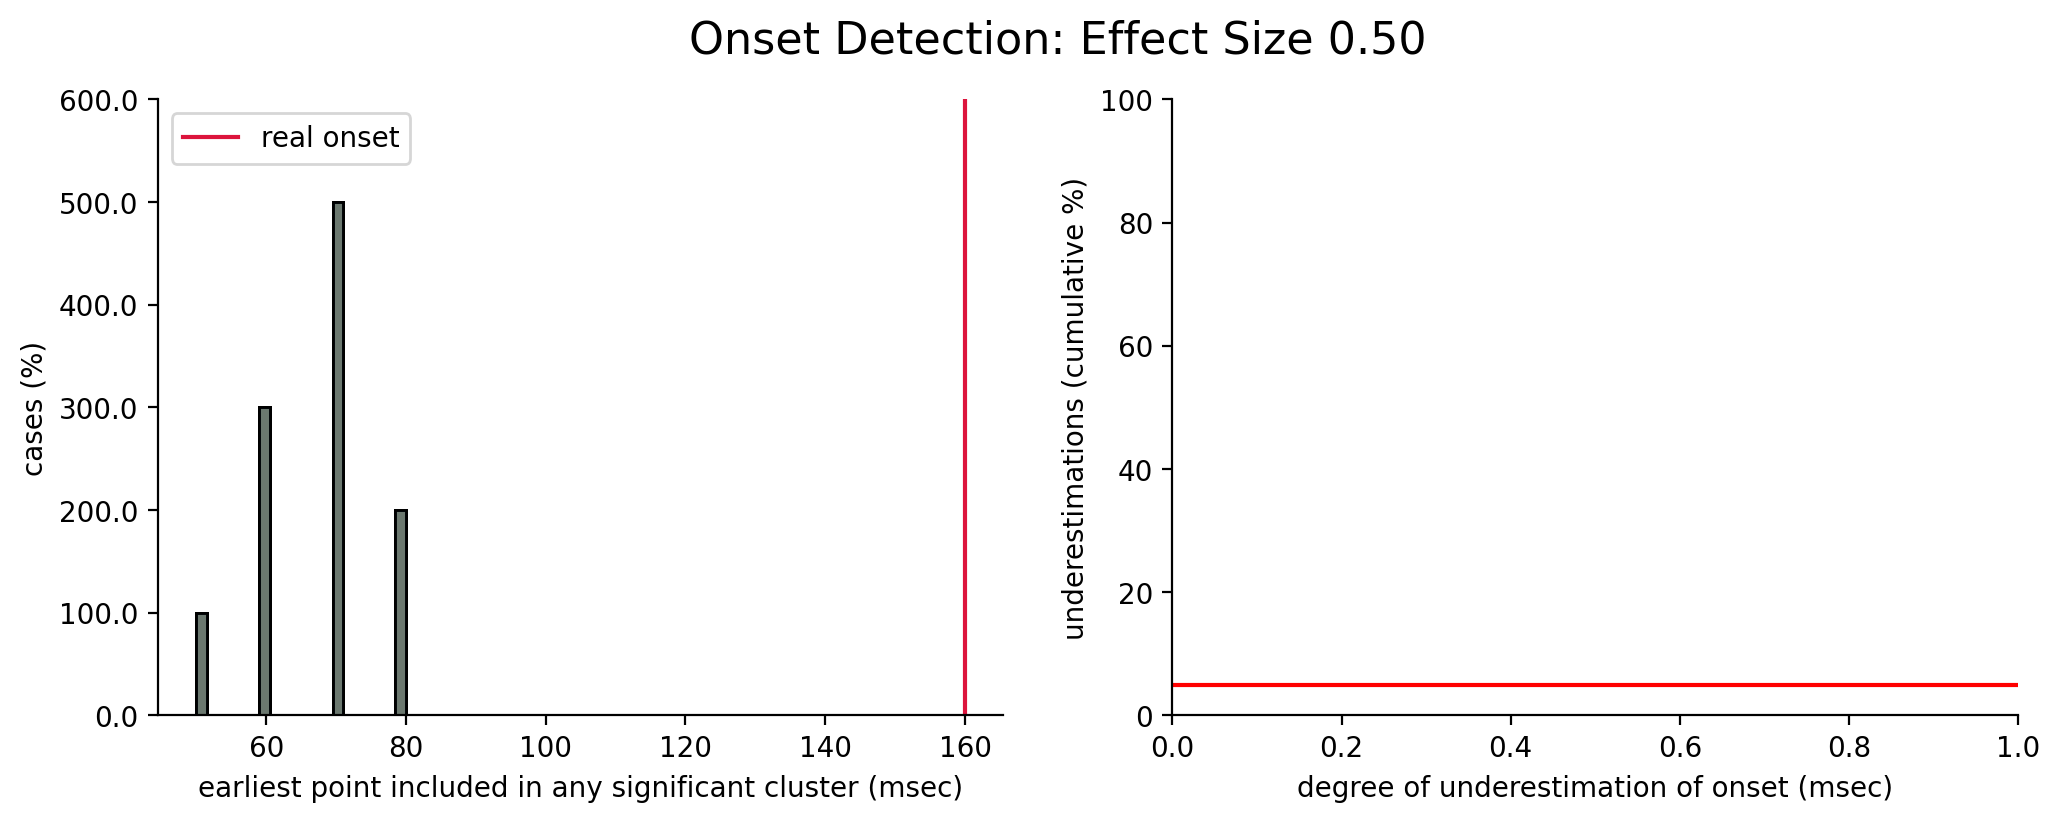

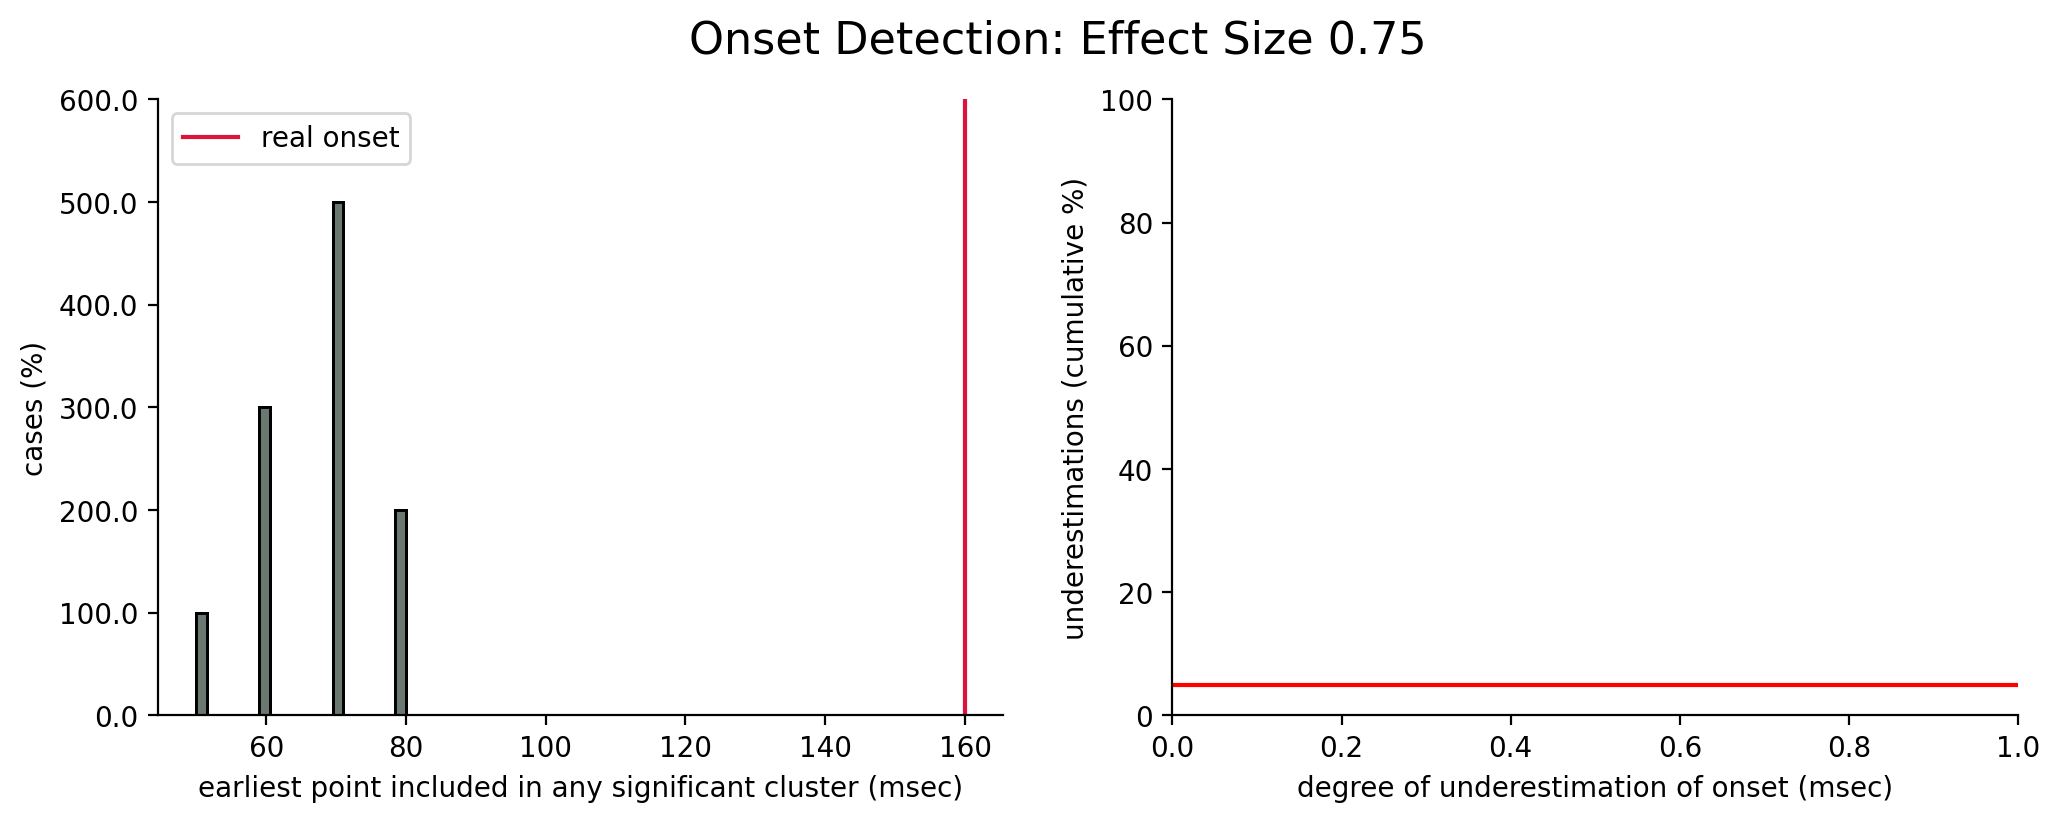

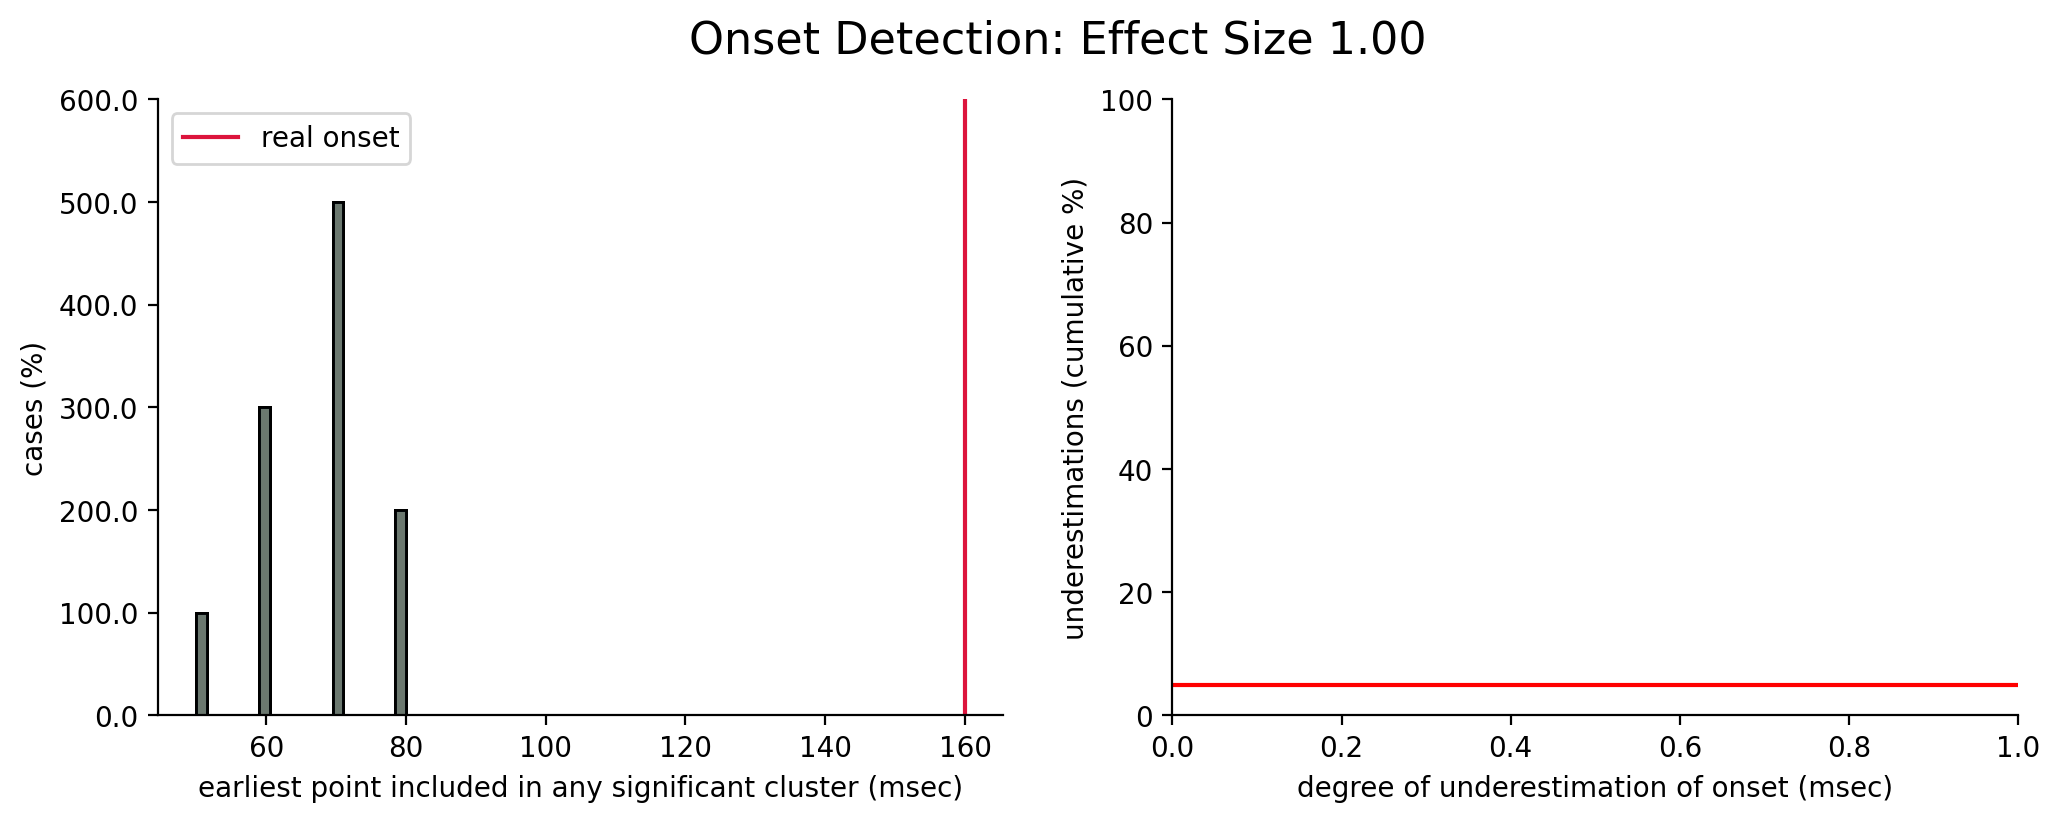

In [90]:
# plot results for each effect size to compare
#
for ii in range(len(all_results)):
    results = all_results[ii]     # use index 0, 1, ... but some will be None
    claims = [r[0] for r in results if r]
    #print(claims[0])
    if claims:
        total_claims = len(claims[0])
        print("total claims=", total_claims)
        #print("rate=", sum([sum(r[0] < 16) for r in claims if r]) / total_claims)
        if (total_claims > 1):
            plot_results(claims, effsizes[ii], ii)

In [551]:
n_clus = [r[1] for r in results if r]
pd.Series(n_clus).value_counts() / len(n_clus) * 100

1    50.0
2    50.0
Name: count, dtype: float64

In [554]:
# using all_results, i.e. results with each effect size

errors = []

for ii, effsize in enumerate(effsizes):
    results = all_results[ii]
    claims = [r[0] for r in results if r]
    total_claims = len(claims)
    early = sum([ sum(r[0] < 16) for r in claims if r]) / total_claims
    late  = sum([ sum(r[0] > 17) for r in claims if r]) / total_claims
    errors.append((early, late))

In [555]:
# for r in claims:
#     print(r[0])
errors

[(1.0, 169.0), (0.0, 244.0), (77.5, 77.5)]

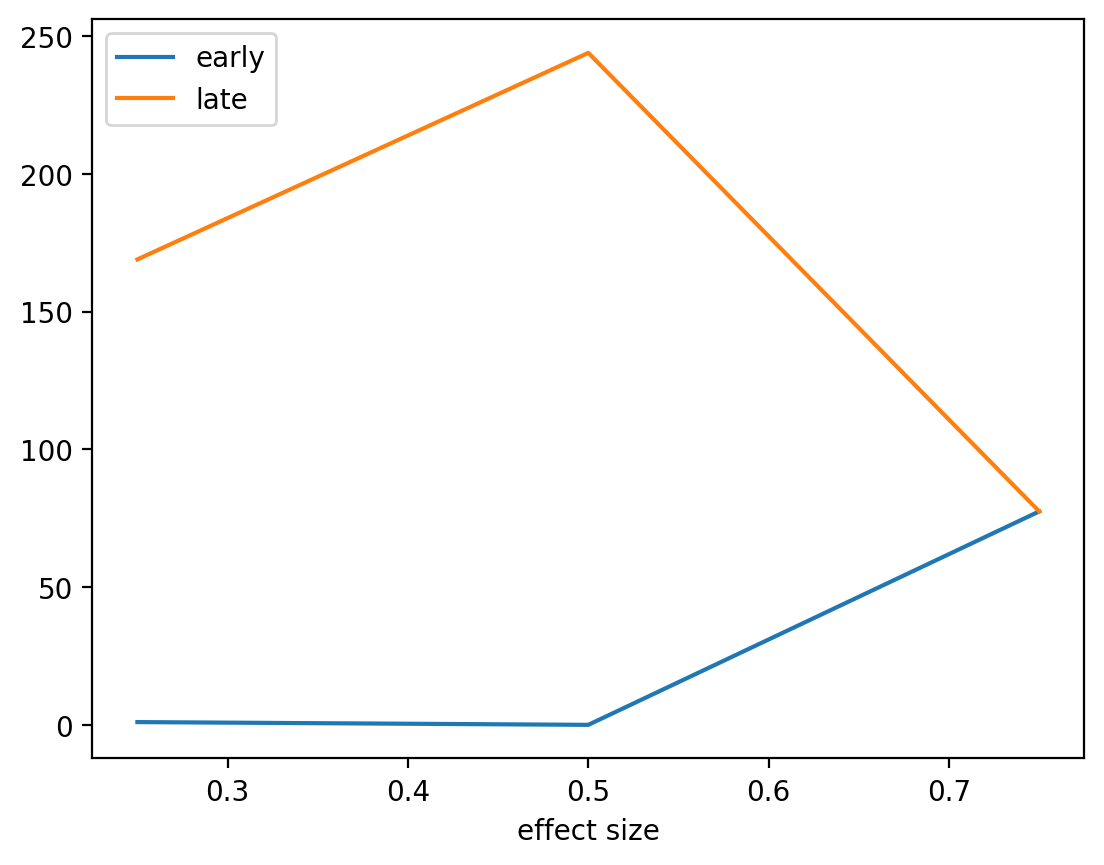

In [556]:
if errors:
    plt.plot(effsizes, errors, label=["early", "late"]);
    plt.legend(loc="upper left");
    plt.xlabel("effect size");